In [1]:
                  import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:12<00:00, 239MB/s]


In [3]:
!ls instance-level_human_parsing/instance-level_human_parsing/Training

Categories    Human	 Images        Instances
Category_ids  Human_ids  Instance_ids  train_id.txt


In [19]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASS = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [20]:
train_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]

In [21]:
def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE,IMAGE_SIZE])

  else:
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE,IMAGE_SIZE])
    image = image / 127.5 - 1 # -1~1값으로 normalization

  return image


In [22]:
def load_data(image_list, mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list, mask=True)
  return image, mask

In [23]:
def data_generator(image_list, mask_list):
  dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
  dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

In [24]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train dataset:", train_dataset )
print("val dataset:", val_dataset )

Train dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
val dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


In [25]:
def convolution_block(block_input, num_filters=256, kernel_size =3,
                      dilation_rate=1, padding='same', use_bias=False):
  x = layers.Conv2D(num_filters, kernel_size=kernel_size, 
                   dilation_rate=dilation_rate, padding='same',
                   use_bias = use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)

  x = layers.BatchNormalization()(x)
  return tf.nn.relu(x)

In [26]:
def DilatedSpatialPyramidPooling(dspp_input):
  dims = dspp_input.shape
  x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
  x = convolution_block(x, kernel_size=1, use_bias=True)
  out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
                                 interpolation='bilinear')(x)

  out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
  out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
  out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
  out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

  x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
  output = convolution_block(x, kernel_size=1)
  return output

In [28]:
def DeeplabV3(image_size, num_classes):
  model_input = keras.Input(shape=(image_size, image_size,3))
  resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)

  x = resnet50.get_layer('conv4_block6_2_relu').output
  x = DilatedSpatialPyramidPooling(x)
  input_a = layers.UpSampling2D(size=(image_size//4//x.shape[1],
                                      image_size//4//x.shape[2]),
                                interpolation='bilinear')(x)

  input_b = resnet50.get_layer('conv2_block3_2_relu').output
  input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

  x = layers.Concatenate(axis=-1)([input_a, input_b])
  x = convolution_block(x)
  x = convolution_block(x)
  x = layers.UpSampling2D(size=(image_size // x.shape[1],
                                image_size // x.shape[2]),
                          interpolation = 'bilinear')(x)
  model_output = layers.Conv2D(num_classes, kernel_size=(1,1), padding='same')(x)
  return keras.Model(inputs= model_input, outputs=model_output)

model = DeeplabV3(image_size = IMAGE_SIZE, num_classes=NUM_CLASS)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [37]:
from keras.optimizers import gradient_descent_v2

In [40]:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
250/250 [==============================] - 124s 403ms/step - loss: 1.1897 - accuracy: 0.6396 - val_loss: 2.7119 - val_accuracy: 0.5836
Epoch 2/20
250/250 [==============================] - 102s 408ms/step - loss: 0.9386 - accuracy: 0.7017 - val_loss: 2.3101 - val_accuracy: 0.6000
Epoch 3/20
250/250 [==============================] - 101s 405ms/step - loss: 0.8301 - accuracy: 0.7346 - val_loss: 1.2108 - val_accuracy: 0.6482
Epoch 4/20
250/250 [==============================] - 102s 407ms/step - loss: 0.7651 - accuracy: 0.7543 - val_loss: 1.1342 - val_accuracy: 0.6832
Epoch 5/20
250/250 [==============================] - 101s 403ms/step - loss: 0.7099 - accuracy: 0.7719 - val_loss: 1.0275 - val_accuracy: 0.7028
Epoch 6/20
250/250 [==============================] - 101s 404ms/step - loss: 0.6355 - accuracy: 0.7964 - val_loss: 0.8282 - val_accuracy: 0.7448
Epoch 7/20
250/250 [==============================] - 101s 404ms/step - loss: 0.5972 - accuracy: 0.8100 - val_loss: 0.8566 -

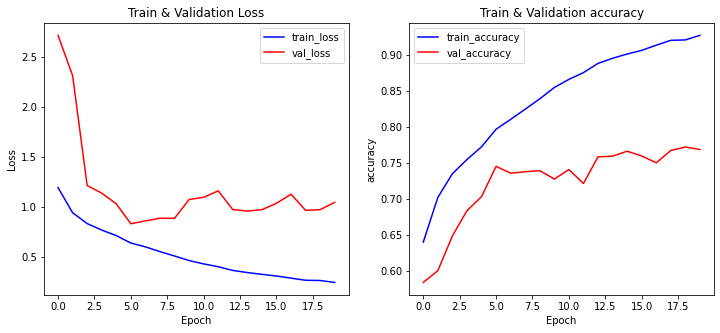

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax2 = fig.add_subplot(1,2,2)
ax2.plot(accuracy, color='blue', label='train_accuracy')
ax2.plot(val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train & Validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.show()


In [43]:
colormap = loadmat('./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat')['colormap']
colormap = colormap * 100
colormap = colormap.astype(np.uint8)

In [50]:
def infer(model, image_tensor):
  predictions = model.predict(np.expand_dims((image_tensor), axis=0))
  predictions = np.squeeze(predictions)
  predictions = np.argmax(predictions, axis=2)

  return predictions

In [51]:
def decode_segmentation_masks(mask, colormap, n_classes):
  r = np.zeros_like(mask).astype(np.uint8)
  g = np.zeros_like(mask).astype(np.uint8)
  b = np.zeros_like(mask).astype(np.uint8)
  for i in range(0, n_classes):
    idx = mask == i
    r[idx] = colormap[i,0]
    g[idx] = colormap[i,1]
    b[idx] = colormap[i,2]
  rgb = np.stack([r,g,b], axis=2)
  return rgb

In [52]:
def get_overlay(image, colored_mask):
  image = tf.keras.preprocessing.image.array_to_img(image)
  image = np.array(image).astype(np.uint8)
  overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0 )
  return overlay

In [56]:
def plot_samples_matplotlib(display_list, figsize=(5,3)):
  _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
  for i in range(len(display_list)):
    if display_list[i].shape[-1] ==3:
      axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    else:
      axes[i].imshow(display_list[i])

  plt.show()

In [57]:
def plot_predictions(images_list, colormap, model):
  for image_file in images_list:
    image_tensor = read_image(image_file)
    prediction_mask = infer(image_tensor=image_tensor, model=model)
    prediction_colormap = decode_segmentation_masks(prediction_mask, colormap,20)
    overlay = get_overlay(image_tensor, prediction_colormap)
    plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize=(18,14))

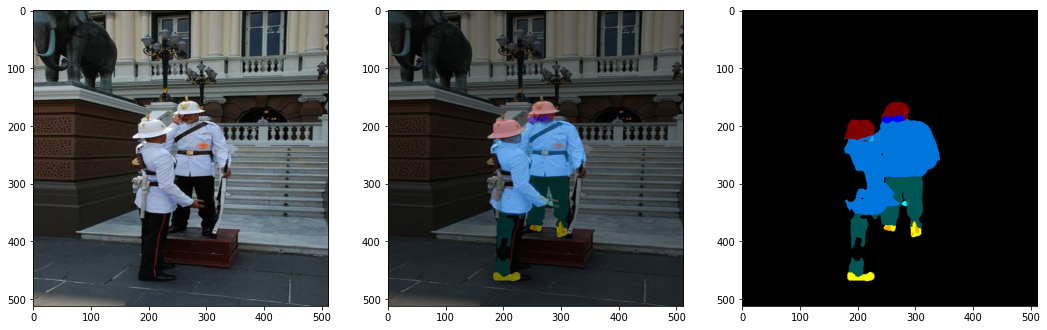

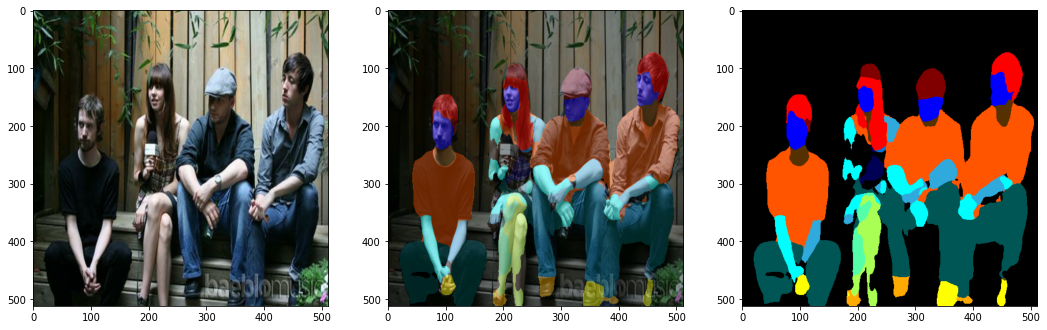

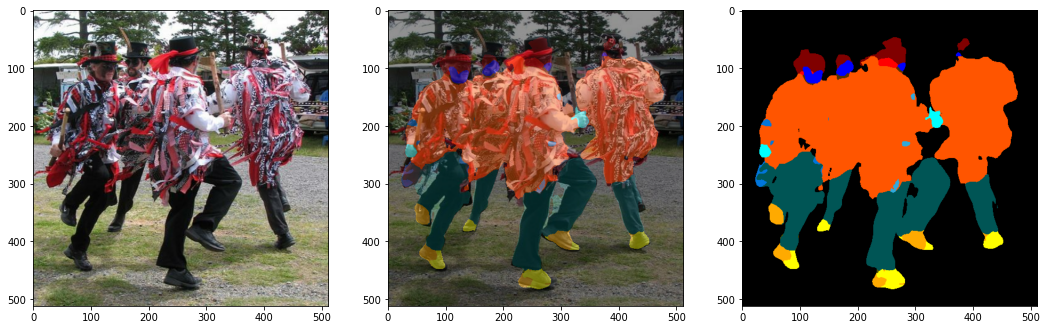

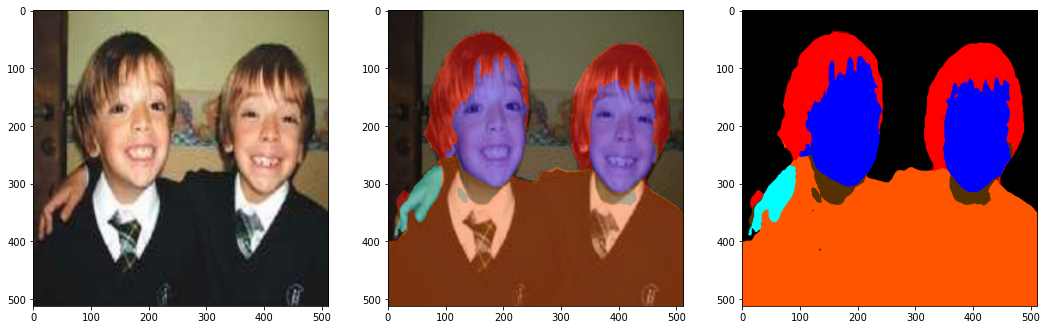

In [58]:
plot_predictions(train_images[:4], colormap, model=model)

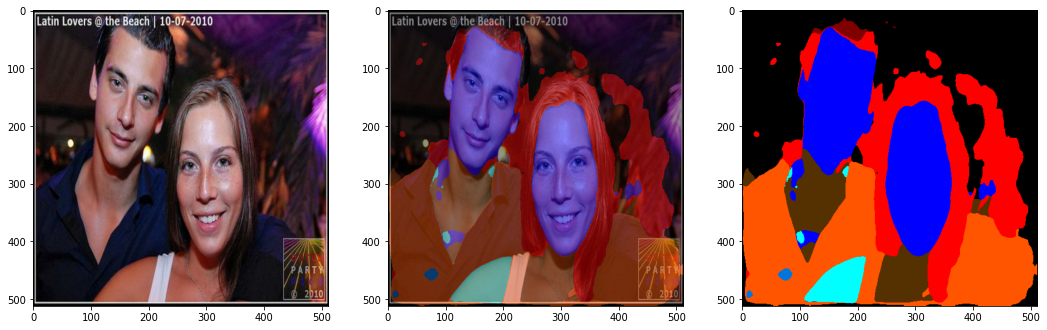

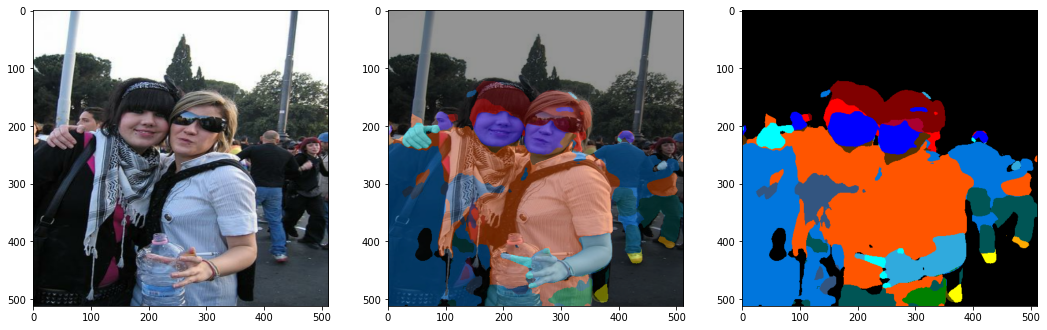

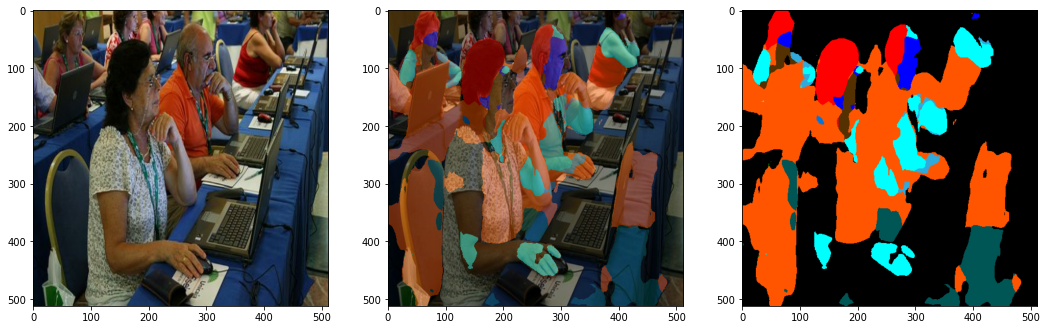

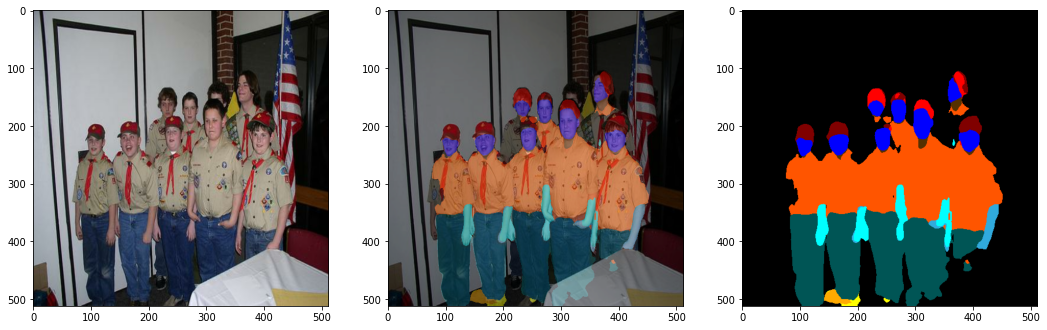

In [59]:
plot_predictions(val_images[:4], colormap, model=model)